In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Загрузка и предобработка датасета

Мы заранее перемещаем кото-собак в одну папку для удобства 

In [2]:
catsAndDogs = os.listdir("./dataset/training_set/CatsAndDogs")
categories = []
for filename in catsAndDogs:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': catsAndDogs,
    'category': categories
})

In [3]:
df

,filename,category
0,cat.1.jpg,0
1,cat.10.jpg,0
2,cat.100.jpg,0
3,cat.1000.jpg,0
4,cat.1001.jpg,0
...,...,...
7995,dog.995.jpg,1
7996,dog.996.jpg,1
7997,dog.997.jpg,1
7998,dog.998.jpg,1


<AxesSubplot:>

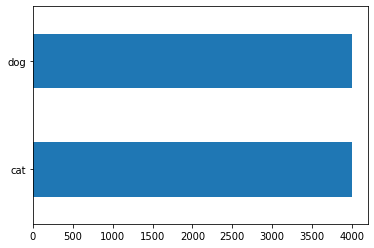

In [4]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
df['category'].value_counts().plot.barh()

Всего котособак у нас 8000, по 4000 в каждой категории

In [5]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

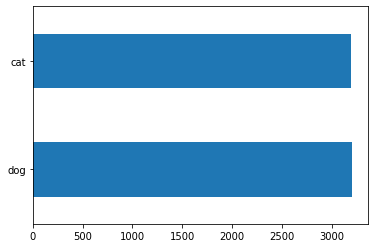

In [6]:
train_df['category'].value_counts().plot.barh()

<AxesSubplot:>

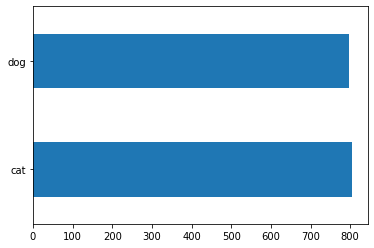

In [7]:
validate_df['category'].value_counts().plot.barh()

###  Тренировочный и проверочный генератор

In [8]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset/training_set/CatsAndDogs", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 6400 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/training_set/CatsAndDogs", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


## Модели

Модель 1

In [11]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(2, activation='relu'))

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 2)                 2

In [12]:
epochs=7
history1 = model1.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/7
426/426 [==============================] - 76s 175ms/step - loss: nan - accuracy: 0.4993 - val_loss: nan - val_accuracy: 0.5013
Epoch 2/7
426/426 [==============================] - 80s 187ms/step - loss: nan - accuracy: 0.4988 - val_loss: nan - val_accuracy: 0.5019
Epoch 3/7
426/426 [==============================] - 81s 189ms/step - loss: nan - accuracy: 0.4995 - val_loss: nan - val_accuracy: 0.5013
Epoch 4/7
426/426 [==============================] - 81s 190ms/step - loss: nan - accuracy: 0.4998 - val_loss: nan - val_accuracy: 0.5006
Epoch 5/7
426/426 [==============================] - 74s 173ms/step - loss: nan - accuracy: 0.4993 - val_loss: nan - val_accuracy: 0.5025
Epoch 6/7
426/426 [==============================] - 64s 151ms/step - loss: nan - accuracy: 0.4990 - val_loss: nan - val_accuracy: 0.5031
Epoch 7/7
426/426 [==============================] - 58s 136ms/step - loss: nan - accuracy: 0.4993 - val_loss: nan - val_accuracy: 0.5019


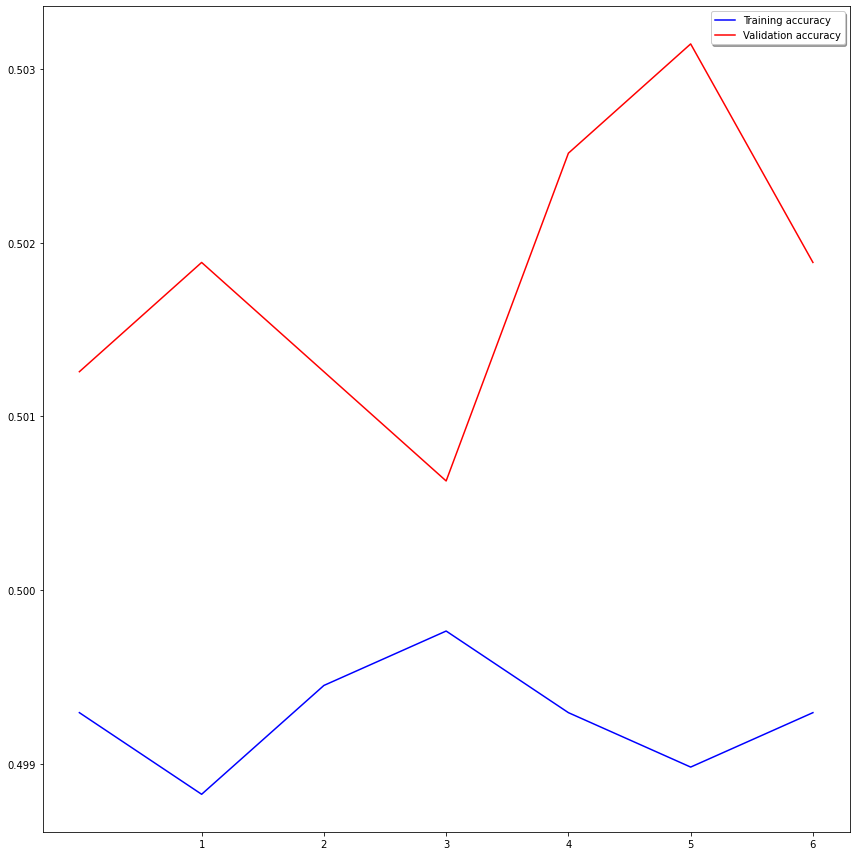

In [13]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax1.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Модель 3

In [14]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(2, activation='relu')) # 2 because we have cat and dog classes

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 61, 61, 64)      

In [15]:
epochs=7
history3 = model3.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/7
426/426 [==============================] - 104s 244ms/step - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5031
Epoch 2/7
426/426 [==============================] - 98s 230ms/step - loss: nan - accuracy: 0.4995 - val_loss: nan - val_accuracy: 0.5038
Epoch 3/7
426/426 [==============================] - 103s 241ms/step - loss: nan - accuracy: 0.4995 - val_loss: nan - val_accuracy: 0.5013
Epoch 4/7
426/426 [==============================] - 102s 240ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.5038
Epoch 5/7
426/426 [==============================] - 103s 242ms/step - loss: nan - accuracy: 0.4988 - val_loss: nan - val_accuracy: 0.5031
Epoch 6/7
426/426 [==============================] - 100s 236ms/step - loss: nan - accuracy: 0.4993 - val_loss: nan - val_accuracy: 0.5025
Epoch 7/7
426/426 [==============================] - 102s 240ms/step - loss: nan - accuracy: 0.4995 - val_loss: nan - val_accuracy: 0.5031


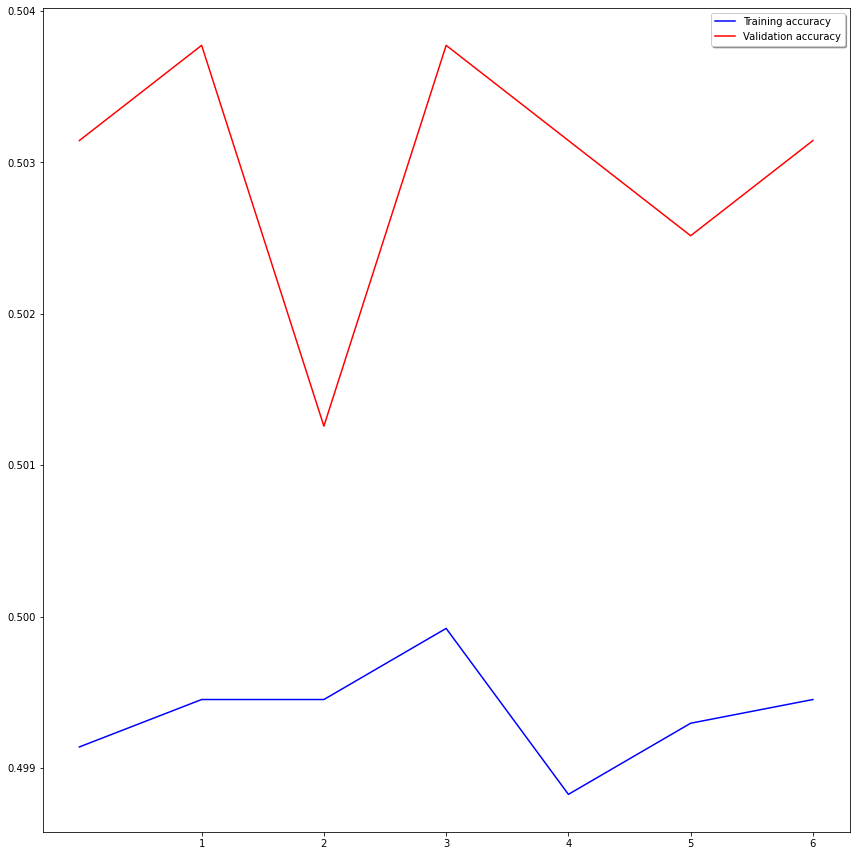

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

ax1.plot(history3.history['accuracy'], color='b', label="Training accuracy")
ax1.plot(history3.history['val_accuracy'], color='r',label="Validation accuracy")
ax1.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()